# Test 

Introduction here

In [1]:
# Typical imports here
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c

In [2]:
import pyND.absorption as abs

## Test data

In [5]:
from scipy.io import readsav

input_filename = 'CIV1548.2i_o.save'
# input_filename = 'rbs2005_SiII1260_o.save'
spec = readsav(input_filename)

In [6]:
spec.keys()

dict_keys(['v', 'f', 'ef', 'ion', 'wni', 'wavc', 'fval', 'gam', 'redshift', 'object', 'vlsr', 'name', 'ra', 'dec', 'gl', 'gb', 'z', 'ycon', 'ycon_sig', 'vnorm', 'fnorm', 'efnorm', 'efnorm1', 'efnorm2', 'sigma0', 'targname', 'sn', 'maxord', 'v1', 'v2', 'vaod1', 'vaod2', 'ncol', 'ncole1', 'ncole2', 'ncolez', 'w', 'w_es', 'w_ec', 'w_et', 'w_ez', 'va', 'vaerr', 'ba', 'baerr', 'm3', 'm3err', 'col3sig', 'col2sig', 'dv90', 'v90a', 'v90b', 'mask_cont', 'vel', 'flux', 'eflux'])

In [16]:
# FIX NON-WRITEABLE ARRAYS due to discontiguous memory
for kkk in spec.keys():
    if isinstance(spec[kkk],(np.ndarray)):
        spec[kkk] = spec[kkk].copy()

In [17]:
velocity = spec['vel'].copy()
flux = spec['flux'].copy()
flux_err = spec['eflux'].copy()
continuum = spec['ycon'].copy()
continuum_err = spec['ycon_sig'].copy()
wavc=spec['wavc'].copy()
fval=spec['fval'].copy()

(-500, 100)

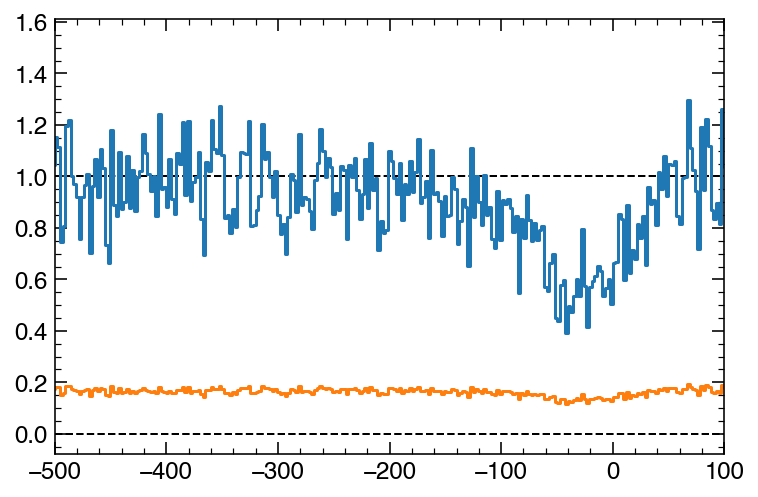

In [18]:
plt.plot(velocity,flux/continuum,drawstyle='steps-mid')
plt.plot(velocity,flux_err/continuum,drawstyle='steps-mid')
abs.plotaxes()
plt.xlim(-500,100)

### Test the new code

In [19]:
# %run pyn_column
# calc_column(velocity,flux,flux_err,
#     continuum,continuum_err,wavc,fval)

In [20]:
def xlimit(x, limits):

   def _ret():  return idx1, idx2

   # x1 = where(ravel(x >= xpos1))[0]  ;  x1 = x1[0]
   # x2 = where(ravel(x > xpos2))[0]  ;  x2 = x2[0] - 1

   idx1 = (np.abs(x - limits[0])).argmin()
   idx2 = (np.abs(x - limits[1])).argmin()

   return _ret()


In [33]:
integration_limits=[spec['v1'],spec['v2']]
integration_limits=[-300,-150]

In [40]:
    # Some constants and flags
    column_factor = 2.654e-15
    flag_sat = False

    velocity = spec['vel'].copy()
    flux = spec['flux'].copy()
    flux_err = spec['eflux'].copy()
    continuum = spec['ycon'].copy()
    continuum_err = spec['ycon_sig'].copy()
    wavc=spec['wavc'].copy()
    fval=spec['fval'].copy()

    # Define the limits of the integration:
    if not integration_limits:
        int_idx = np.full(np.size(velocity),False)
        xlim1, xlim2 = \
            xlimit(velocity,[spec['v1'],spec['v2']])
        int_idx[xlim1:xlim2] = True
    else:
        int_idx = np.full(np.size(velocity),False)
        xlim1, xlim2 = \
            xlimit(velocity,integration_limits)
        int_idx[xlim1:xlim2] = True

    #Define the velocity spacing
    delv = np.median(velocity[1:]-velocity[:-1])

    # Test for clearly saturated pixels:
    idx_saturation = (flux <= 0.)
    if idx_saturation.sum() > 0: flag_sat = True

    # Fix saturation if it's present.
    flux[idx_saturation] = np.abs(flux[idx_saturation])
    flux[(flux==0)] = 2.*flux_err[(flux==0)]

    # Create an optical depth array and its error
    tau_array = np.log(continuum / flux)
    tau_array_err = np.sqrt((flux_err/flux)**2)

    tau_int = np.sum(tau_array[int_idx]*delv)
    tau_int_err = \
     np.sqrt(np.sum((tau_array_err[int_idx]*delv)**2))

    # Create an apparent column density array
    nav_array = tau_array/(wavc*fval*column_factor)
    nav_err = tau_array_err/(wavc*fval*column_factor)

    # Integrate the apparent column density profiles
    column = tau_int/(wavc*fval*column_factor)

    # Error in the column
    column_err = tau_int_err/(wavc*fval*column_factor)

    # Continuum error
    column_err_cont = \
        np.sum(((continuum_err[int_idx]/continuum[int_idx])*delv)) /\
         (wavc*fval*column_factor)

    # Background uncertainty
    z_eps = 0.01  # Fractional bg error
    yc1 = continuum[int_idx]*(1.-z_eps)
    y1  = flux[int_idx]-continuum[int_idx]*z_eps
    tau1 = np.sum(np.log(yc1/y1)*delv)
    col1 = tau1 / (wavc*fval*column_factor)
    column_err_zero = np.abs(col1-column)

    # Combine errors
    column_err_total = np.sqrt(column_err**2 \
        +column_err_cont**2)



In [35]:
np.log10(column),column_err/column*np.log10(np.e)

(13.09315733229834, 0.15186661302157617)

#### $\tau_a(v)$ profile

(-1, 5)

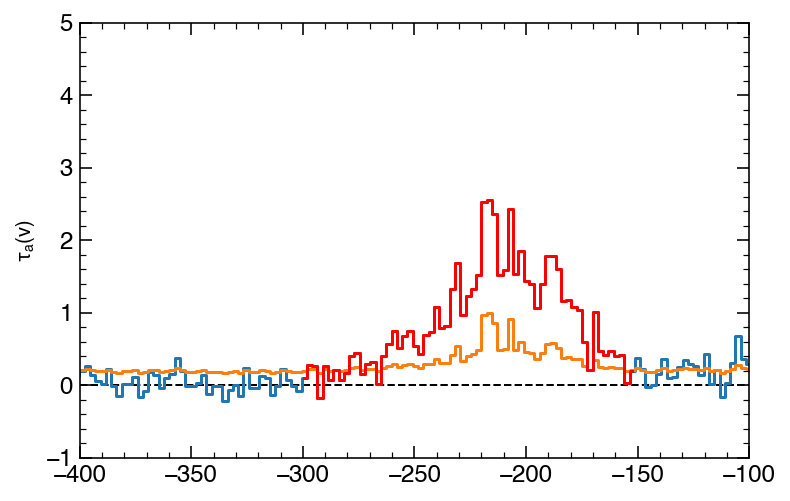

In [97]:
plt.plot(velocity,tau_array,drawstyle='steps-mid')
plt.plot(velocity,tau_array_err,drawstyle='steps-mid')
plt.plot(velocity[int_idx],tau_array[int_idx],color='red',drawstyle='steps-mid')
abs.plotzero()
plt.ylabel('$\\tau_a(v)$')
plt.xlim(-400,-100)
plt.ylim(-1,5)

#### $N_a(v)$ profile

(-100000000000.0, 1000000000000.0)

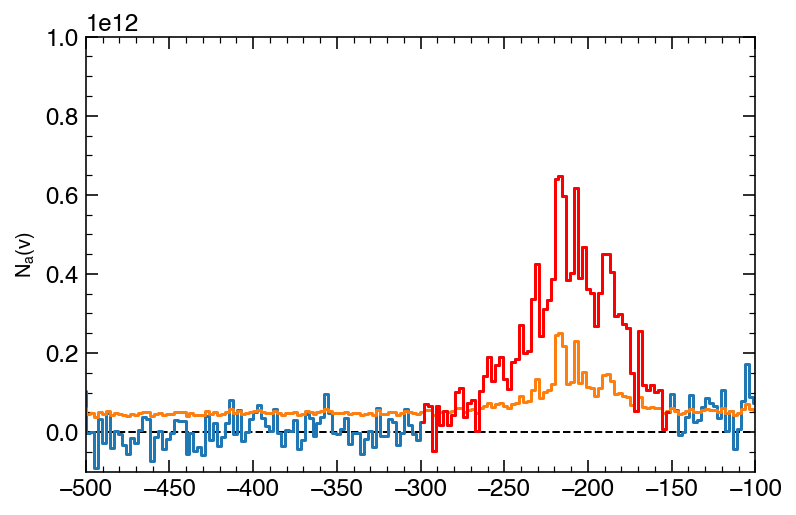

In [98]:
plt.plot(velocity,nav_array,drawstyle='steps-mid')
plt.plot(velocity,nav_err,drawstyle='steps-mid')
plt.plot(velocity[int_idx],nav_array[int_idx],color='red',drawstyle='steps-mid')
abs.plotzero()
plt.ylabel('$N_a(v)$')
plt.xlim(-500,-100)
plt.ylim(-0.1e12,1e12)

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


```

```
# Testing `pyNorm.aod.pyn_column`

In [49]:
from scipy.io import readsav

input_filename = 'CIV1548.2i_o.save'
# input_filename = 'rbs2005_SiII1260_o.save'
spec = readsav(input_filename)

In [33]:
integration_limits=[spec['v1'],spec['v2']]
integration_limits=[-300,-150]

In [50]:
from pyNorm.aod import pyn_column

#### Calculate the column density using the velocity limits in the save file

In [51]:
spec_out = pyn_column(spec)
spec_out['ncol'], spec_out['necol1']

(12.715295611673989, 0.2667286587073857)

#### Calculate the column density using the velocity limits from above

In [45]:
spec_out = pyn_column(spec,integration_limits)
spec_out['ncol'], spec_out['necol1']

(13.09315733229834, 0.15471638852989902)

#### Calculate the column density using arbitrary limits

In [47]:
spec_out = pyn_column(spec,integration_limits = [-100,-50])
spec_out['ncol'], spec_out['necol1']

(13.228297797939614, 0.07199311585119089)